In [2]:
import os, dotenv

dotenv.load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COMPOSIO_API_KEY"] = os.getenv("COMPOSIO_API_KEY")

In [4]:
## Models
from langchain_google_genai import  ChatGoogleGenerativeAI
from langchain_groq import  ChatGroq

gemini_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llama_model = ChatGroq(model="llama-3.3-70b-versatile")
deepseek_model = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
## Tools
from pydantic import BaseModel, Field
from typing import Annotated
from langchain_core.tools import  tool

# @tool
class LINKEDIN_AGENTS(BaseModel):
    """
    The LinkedIn Agents Team to perform tasks related to LinkedIn
    """
    task : Annotated[str, Field(description="The task to be performed by the LinkedIn Agents Team")]

class EMAIL_AGENTS(BaseModel):
    """
    The Email Agents that perform email related tasks.
    """
    task : Annotated[str, Field(description="The task to be performed by Email Agents")]

In [6]:
from langchain_core.messages import SystemMessage, AIMessage, ToolMessage, HumanMessage, AnyMessage

PROMPT = """
You are Aztrogent, an AI Assistant for Aasher Kamal who is an AI Developer. You help him in automating his tasks. 
---
Follow these guidelines:

1. Friendly Introduction & Tone
   - Greet the user warmly and begin the conversation in a friendly tone.
   - Maintain a polite, friendly and informal style.

2. Available Agents
    - You have access to your Colleague Agents that are specialized at performing specific tasks.
    - The `LINKEDIN_AGENTS` is a team of Agents that work together to accomplish a task related to LinkedIn, like writing and posting a new post, finding jobs on LinkedIn etc.
    - The `EMAIL_AGENTS` is a team of Agents that will do all tasks related to emails, like writing/drafting emails, sending and checking emails of user.

3. Task Delegation
   - If the user ask to do some task related to LinkedIn:
       a) Gather complete information about the task from the user. If you are not sure about the task, ask the user for more information.
       b) Call `LINKEDIN_AGENTS` team to perform that task. Always give complete task description to these Agents team.
       c) When `LINKEDIN_AGENTS` team has performed the task, tell the user that the task is completed.
       d) If any function call/tool call (i.e calling colleague agents) fails, retry it.
   - If the given task is related to Emails:
       a) Make sure you have gathered complete information, like the email of the person whom you are sending the email to.
       b) Call `EMAIL_AGENTS` with the clear task description.
       c) Once the `EMAIL_AGENTS` perform the task, let user know that the task has been completed.

4. Information Gathering
   - Always make sure you provide the complete, accurate information to your colleague Agents.
   - If the user is uncertain, clarify user's intent.

By following these guidelines, you ensure a smooth and user-friendly experience: greeting the user, identifying tasks, calling agents when needed, and finalizing the task execustion.
---

### Communication Style

- **Tone**: Friendly, professional, and reassuring.
- **Style**: Informal, confident, and approachable.
"""

## Main Agent
main_agent = gemini_model.bind_tools([LINKEDIN_AGENTS, EMAIL_AGENTS])

In [7]:
from langgraph.graph import MessagesState

# Main Agent Calling Node
def call_model(state: MessagesState):

    response = main_agent.invoke([SystemMessage(content=PROMPT)] + state["messages"])
    return {"messages": [response]}

### LinkedIn Agents Graph

In [8]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated

## State
class InternalState(TypedDict):
    query: Annotated[list[AnyMessage], add_messages]

## LinkedIn Agents Node
async def linkedin_agent_team(state: InternalState):

    messages = state["query"]
    last_message = messages[-1]

    tool_messages = []

    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
    # Process every call in the list
      for call in last_message.tool_calls:
          print("Processing tool call: %s", call)
          tool_name = call.get("name")
          tool_id = call.get("id")
          args = call.get("args")


          if tool_name == "LINKEDIN_AGENTS":
              response = graph.invoke(last_message)
              res = LINKEDIN_AGENTS(**args)
              print(f"****LinkedI Agents: {res}******")

              tool_msg = ToolMessage(
                    name=tool_name,
                    content="The task has successfully been completed!",
                    tool_call_id=tool_id  # Use the extracted tool_call_id
                )
              tool_messages.append(tool_msg)

    return {"query": tool_messages}

## XYZ Agent Node
def xyz_agent(state: InternalState):

    tool_msg = ToolMessage(
                    name=tool_name,
                    content="The task has successfully been completed!",
                    tool_call_id=tool_id  # Use the extracted tool_call_id
                )
    return {"query": tool_msg}

# Build graph
builder = StateGraph(InternalState)
builder.add_node("linkedin_agent_team", linkedin_agent_team)
builder.add_node("xyz", xyz_agent)

builder.add_edge(START, "linkedin_agent_team")
builder.add_edge("linkedin_agent_team", "xyz")
builder.add_edge("xyz", END)
subgraph = builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


### Email Agents Graph

In [9]:
## Email Agent
async def email_agents_as_tool(state: MessagesState):
    """
    Determine if the conversation should continue to tools or end
    """
    messages = state["messages"]
    last_message = messages[-1]

    tool_messages = []

    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
    # Process every call in the list
      for call in last_message.tool_calls:
          print("Processing tool call: %s", call)
          tool_name = call.get("name")
          tool_id = call.get("id")
          args = call.get("args")

          if tool_name == "EMAIL_AGENT":

              res = args
              print(f"****Email: {res}******")

              tool_msg = ToolMessage(
                    name=tool_name,
                    content="The email task has successfully been completed!",
                    tool_call_id=tool_id  # Use the extracted tool_call_id
                )
              tool_messages.append(tool_msg)

    return {"messages": tool_messages}     

In [10]:
from typing import Literal

## Conditional Edge
async def tools_condition(state: MessagesState) -> Literal["linkedin_agents",  "email_agent", "__end__"]:
    """
    Determine if the conversation should continue to tools or end
    """
    messages = state["messages"]
    last_message = messages[-1]

    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
      for call in last_message.tool_calls:
        tool_name = call.get("name")
          
        if tool_name == "LINKEDIN_AGENTS":
            return "linkedin_agents"

        elif tool_name == "EMAIL_AGENT":
            return "email_agent"

    return "__end__"

In [11]:
def linkedin_agents(state: MessagesState):
    response  = subgraph.invoke(
        {"query": state["messages"]}
    )
    return {"messages": [response]}

In [17]:
class DELEGATE_TO_COLLEAGUE_AGENTS(BaseModel):
    team: Literal["LinkedIn", "Gmail", "GitHub"]
    task: str

In [44]:
graphs_by_name = {"LinkedIn": subgraph, "Gmail": email_agents_as_tool, "GitHub": "github_graph"}

In [25]:
from langchain_core.tools import tool
@tool
def delegate_to_colleague_agents(details: DELEGATE_TO_COLLEAGUE_AGENTS):
    """Tool to delegate the task to colleague agents team"""
    response  = graphs_by_name[details.team].invoke(
    {"messages": [HumanMessage(content=details.task)]}
)   
    return response["messages"][-1].content

In [45]:
def agent_tools_condition(state: MessagesState):
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and state["messages"][-1].tool_calls:
        for call in last_message.tool_calls:
            tool_name = call.get("name")

            if tool_name == "delegate_to_colleague_agents":
                return "handoff_node"

            elif tool_name == "UPDATE_MEMORY":
                return "update_memory"

    return "__end__"

In [46]:
def update_memory(state: MessagesState):
    pass

In [47]:
def handoff_tool_node(state: MessagesState):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = graphs_by_name[tool_call["name"]]
        args = tool_call["args"]
        
        response  = tool.invoke(
        {"query": [HumanMessage(content=args.task)]}
        )
        result.append(ToolMessage(content=response, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [54]:
def test_node(state: MessagesState):
    response = subgraph.invoke(
        {"query": [HumanMessage(content=state["messages"][-1].content)]}
    )
    return {"messages": [ToolMessage(content=response, tool_call_id=state["messages"][-1].tool_calls[-1]["id"])]}

In [57]:
## Main Agent Graph
from langchain_core.runnables import RunnableConfig
from langgraph.graph import  MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
# workflow.add_node("linkedin_agents", builder.compile())
# workflow.add_node("email_agent", email_agents_as_tool)
workflow.add_node("handoff_node", handoff_tool_node )
workflow.add_node("update_memory", update_memory)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", agent_tools_condition, ["handoff_node", "update_memory", "__end__"])
workflow.add_edge("handoff_node", "agent")
workflow.add_edge("update_memory", "agent")
# workflow.add_edge("email_agent", "agent")
# workflow.add_edge("linkedin_agents", "agent")

checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)


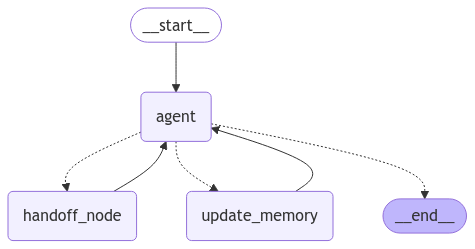

In [58]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [137]:
async def invoke_graph(question: str, thread_id="1"):

    config = {"configurable": {"thread_id": thread_id}}
    # Prepare the messages state
    initial_state = {
        "messages": [HumanMessage(content=question)]
    }

    # Execute the workflow
    async for chunk in app.astream(initial_state, config=config, stream_mode="values"):
        response_message = chunk["messages"][-1]
        if hasattr(response_message, 'content'):
            response_message.pretty_print()


In [138]:
await invoke_graph(question="write a post on the new tech news of today and post them on my linkedin")

================================ Human Message =================================

write a post on the new tech news of today and post them on my linkedin
================================== Ai Message ==================================

Hey Aasher, I can help you with that! I'll write a post about today's tech news and post it on your LinkedIn. Just to be sure, do you have any specific topics or sources you'd like me to focus on, or should I just go with the general top news?


In [139]:
await invoke_graph(question="i want to post about New Qwen-2 model. Ask linkedin agents to do this")

================================ Human Message =================================

i want to post about New Qwen-2 model. Ask linkedin agents to do this
================================== Ai Message ==================================

Alright, I'll create a LinkedIn post about the new Qwen-2 model and have it posted on your LinkedIn. I'll use the LinkedIn Agents Team to get this done for you.
Tool Calls:
  LINKEDIN_AGENTS (b14ee3be-1f6e-444d-9e94-9119a5379259)
 Call ID: b14ee3be-1f6e-444d-9e94-9119a5379259
  Args:
    task: Create a LinkedIn post about the new Qwen-2 model and post it on LinkedIn.


InvalidUpdateError: Must write to at least one of ['query']

In [141]:
await invoke_graph(question="Can you write an email to Richard thanking him about the watch gift.", thread_id="2")

================================ Human Message =================================

Can you write an email to Richard thanking him about the watch gift.
================================== Ai Message ==================================
Tool Calls:
  EMAIL_AGENT (2ce0d010-dce8-407b-aee7-01c9e78f82b9)
 Call ID: 2ce0d010-dce8-407b-aee7-01c9e78f82b9
  Args:
    task: Write an email to Richard thanking him for the watch gift.
Processing tool call: %s {'name': 'EMAIL_AGENT', 'args': {'task': 'Write an email to Richard thanking him for the watch gift.'}, 'id': '2ce0d010-dce8-407b-aee7-01c9e78f82b9', 'type': 'tool_call'}
****Email: {'task': 'Write an email to Richard thanking him for the watch gift.'}******
================================= Tool Message =================================
Name: EMAIL_AGENT

The email task has successfully been completed!
================================== Ai Message ==================================

Okay, I have written an email to Richard thanking him for the wat